# Gradient-based solver for Lasso regression

In this notebook, you will create a **gradient descent** solver for **Lasso regression** and then compare it to the built-in solver in `sklearn.linear_model`.

## 1. Set up notebook and create data set

After loading in some standard packages, we create a synthetic data set consisting of data points `(x,y)`:
* `x`: 100-dimensional vector whose coordinates are independent draws from a standard normal (Gaussian) distribution
* `y`: response value given by `y = wx + e` where `w` is a target regression function and `e` is Gaussian noise

We will fix `w` to be the 100-dimensional vector whose first ten coordinates are exactly 1.0, and whose remaining coordinates are zero. Thus only the first ten coordinates of `x` are relevant to the regression task.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)

The following procedure, **generate_data**, creates a data set of a specified number of points. It is invoked as follows:
* `trainx, trainy = generate_data(n)`

Here:
* `n` is the target number of points
* `trainx`: `nx100` array of data points
* `trainy`: array of `n` response values

In [2]:
def generate_data(n):
    d = 100
    # Remove these lines later    
    #d = 10
    #np.random.seed(0)
    #
    w = np.zeros(d)
    for i in range(0,10):
        w[i] = 1.0
    #
    trainx = np.random.normal(size=(n,d))
    e = np.random.normal(size=(n))
    trainy = np.dot(trainx, w) + e
    #
    return trainx, trainy

## 2. Gradient descent solver for Lasso regression

<font color="magenta">**For you to do:**</font> Define a procedure, **lasso_regression_GD**, that uses gradient descent to solve the lasso regression problem. It is invoked as follows:

* `w,b,losses = lasso_regression_GD(x,y,C)`

Here, the input consists of:
* training data `x,y`, where `x` and `y` are numpy arrays of dimension `n`-by-`d` and `n`, respectively (if there are `n` training points)
* regularization constant `C`

The function should find the `d`-dimensional vector `w` and offset `b` that minimize the lasso regression loss function (with regularization constant `C`), and return:
* `w` and `b`
* `losses`, an array containing the lasso regression loss at each iteration

<font color="magenta">Advice:</font> First figure out the derivative, which has a relatively simple form. Next, when implementing gradient descent, think carefully about two issues.

1. What is the step size?
2. When has the procedure converged?

Take the time to experiment with different ways of handling these.

In [3]:
import numpy as np
def lasso_regression_GD(x,y, C, d = 100):    
    
    def compute_se(pred, w):
        residual = y - pred
        return np.dot(residual, residual) + C * np.dot(w, w)
    
    def compute_derivatives(w, pred):
        r = y - pred
        dw = np.sum(-2 * r.reshape((-1, 1)) * x, axis = 0) + C * w / np.abs(w)
        db = -2 * np.sum(r)
        return dw, db

    
    w, b, n  = np.random.random(d), np.random.random(), x.shape[0]
    lambda_ = 0.001
    num_iters = 500
    losses = [float('inf')]
    tolerance = 1e-20 * n
    while num_iters >=0:
        pred = np.matmul(x, w.T) + b
        loss = compute_se(pred, w)
        if loss > losses[-1] or losses[-1] - loss < tolerance:
            break

        losses.append(loss)
        dw, db = compute_derivatives(w, pred)
        w = w - lambda_ * dw
        b = b - lambda_ * db
        num_iters -= 1

    return w, b, losses[1:]


In [4]:
n = 200
trainx, trainy = generate_data(n)
w, b, losses = lasso_regression_GD(trainx, trainy, 1)
print(w[0:20],len(losses), losses[-1]/ 200, b)

[ 0.94073341  0.96506487  0.93925006  0.97098496  0.91859652  1.11731132
  1.07875331  0.98104094  0.86713342  0.96719525 -0.06438796  0.05093001
 -0.04627714  0.03370032  0.05107963 -0.21896455  0.02233648 -0.00189489
  0.15993353 -0.00525304] 97 0.545991769017 0.078584349444


Let's try it out and print a graph of the loss values during the optimization process.

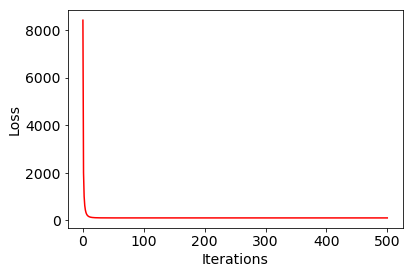

In [5]:
# Generate 200 data points
n = 200
x,y = generate_data(n)
# Set regularization constant
C = 0.001
# Run gradient descent solver
w, b, losses = lasso_regression_GD(x,y,C)
# Plot the losses
plt.plot(losses,'r')
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.show()

<font color="magenta">**Something to think about**</font>

1. In setting the step size, does it work to use a fixed schedule 1/t? Why or why not?

2. Can you set up the gradient descent procedure in such a way that on each iteration, the loss monotonically decreases?


## 3. Evaluate the gradient descent solver

Now let's compare the regressor found by your gradient descent procedure to that returned by the built-in lasso regression solver in `sklearn`. We will compare them in two ways:
* Their MSE values
* The distance between the corresponding `w`-vectors

The latter should be smaller than 10^{-4}.


In [6]:
def compute_mse(w,b,x,y):
    print((np.dot(x, w) + b).shape)
    residuals = y - (np.dot(x, w) + b)
    return np.dot(residuals, residuals)/n

In [7]:
# Generate 200 data points
n = 200
x,y = generate_data(n)
# Set regularization constant
C = 0.001
# Run gradient descent solver and compute its MSE
w, b, losses = lasso_regression_GD(x,y,C)
# Use built-in routine for lasso regression and compute MSE
regr = linear_model.Lasso(alpha=C, max_iter=5000)
regr.fit(x, y)
# Print MSE values and L2 distance between the regression functions
print("MSE of gradient descent solver: ", compute_mse(w,b,x,y))
print("MSE of built-in solver: ", mean_squared_error(regr.predict(x), y))
print("Distance between w-coefficients: ", np.linalg.norm(w-regr.coef_))

(200,)
MSE of gradient descent solver:  0.521333906153
MSE of built-in solver:  0.521720576836
Distance between w-coefficients:  0.0531219417359


<font color="magenta">**Something to think about**</font>

The data was originally generated using a linear function in which only ten of the 100 features (the first ten) were relevant. Does the vector `w` returned by lasso regression correctly identify the relevant features?

In [8]:
np.sqrt(np.sum((w - regr.coef_) ** 2))

0.053121941735920879